# Digit Classification
In this tutorial, we will use graph kernels to classify hand-written digits. Each datapoint is a 8x8 image of a digit. There are 10 classes in total, and each class refers to a digit. The dataset is contained in scikit-learn and we can load it using the *load_digits()* function.

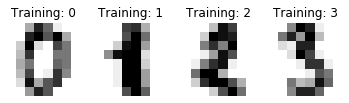

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
import warnings
warnings.filterwarnings('ignore')

digits = load_digits()

images = digits.images
n_samples, height, width = images.shape
y = digits.target
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.axis('off')
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % y[i])

We will now transform the digits into graphs and perform graph classification. We will transform each image into a square grid graph. Each pixel corresponds to a node. Two nodes are connected by an edge if they are direct neighbors. For instance, pixel (0,0) is connected to pixel (1,0) and to pixel (0,1). Note also that the node attributes (i.e., pixel intensities) are transformed into discrete labels, and that the edges are also assigned dicrete labels (i.e., labels 1 and 2 for the horizontal and vertical edges, respectively).

In [2]:
from grakel import Graph

print("Transforming images to graphs")
graphs = list()
edges = list()
edge_labels = dict()
for i in range(height):
    for j in range(width):
        if j < width-1:
            edges.append((i*height+j, i*height+j+1))
            edge_labels[(i*height+j, i*height+j+1)] = 1
        if i < height-1:
            edges.append((i*height+j, (i+1)*height+j))
            edge_labels[(i*height+j, (i+1)*height+j)] = 2

for i in range(n_samples):
    node_labels = dict()
    for j in range(height):
        for k in range(width):
            node_labels[j*height+k] = int(images[i,j,k]/4)
    
    graphs.append(Graph(edges, node_labels=node_labels, edge_labels=edge_labels))

Transforming images to graphs


We next split the dataset into a training and a test set.

In [3]:
print("Splitting dataset into train/test (1000/100 instances)")
graphs_train, graphs_test = graphs[:1000], graphs[1000:1100]
y_train, y_test = y[:1000], y[1000:1100]

Splitting dataset into train/test (1000/100 instances)


We finally use the *neighborhood subgraph pairwise distance* kernel to generate the two kernel matrices and classify the digits. Note that this kernel can handle both node labels and edge labels. To perform classification, we pass the two matrices on to the SVM classifier, and we compute the accuracy of the predictions.

In [4]:
from time import time
from grakel.kernels import NeighborhoodSubgraphPairwiseDistance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize neighborhood subgraph pairwise distance kernel
gk = NeighborhoodSubgraphPairwiseDistance(r=3, d=2)

print("Computing kernel matrics\n")
t0 = time()
K_train = gk.fit_transform(graphs_train)
K_test = gk.transform(graphs_test)
print("done in %0.3fs\n" % (time() - t0))

print("Classifying digits\n")
# Initialize SVM
clf = SVC(kernel='precomputed')

# Fit on the train Kernel
clf.fit(K_train, y_train)

# Predict and test.
y_pred = clf.predict(K_test)

# Calculate accuracy of classification.
print("Classification accuracy: %0.2f" % accuracy_score(y_test, y_pred))

Computing kernel matrics

done in 33.948s

Classifying digits

Classification accuracy: 0.90
